# CNN: Optimized: MobileNetV2
---

#### Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, confusion_matrix

#### Parameters

In [20]:
data_dir = 'data/cbis-ddsm-roi/' 
model_dir = 'models/MobileNetV2/'
model_start_no = 0
model_save_no = model_start_no+1
batchs = 16
epochs = 50

#### Import Data

In [28]:
# Load data
images = np.load(f'{data_dir}/data_original.npy')
imagesR = np.load(f'{data_dir}/data_rot180.npy')
imagesT = np.load(f'{data_dir}/data_T.npy')
labels = np.load(f'{data_dir}/data_labels_segment.npy')

#### Stratified Split for Training, Validation, and Testing

In [4]:
# Split into train (80%) and temp (20%)
images_train, images_temp, labels_train, labels_temp = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=69
)
# Split temp into validation and test (50% of temp, 10% overall)
images_valid, images_tests, labels_valid, labels_tests = train_test_split(
    images_temp, labels_temp, test_size=0.5, stratify=labels_temp, random_state=69
)

In [29]:
ds = {'train': tf.data.Dataset.from_tensor_slices((images, labels)),
      'valid': tf.data.Dataset.from_tensor_slices((imagesT, labels)),
      'tests': tf.data.Dataset.from_tensor_slices((imagesR, labels))}

In [30]:
def preprocess(image, label, target_size=(224, 224)):
    img = tf.expand_dims(image, axis=-1)
    img = tf.image.grayscale_to_rgb(img)
    img = tf.image.resize(img, target_size)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

In [31]:
for key in ds: 
    ds[key] = ds[key].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds[key] = ds[key].batch(batchs).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Build + Compile Model

In [38]:
# Add data augmentation using a Keras augmentation layer
augmentation_layer = tf.keras.layers.RandomZoom(0.5)
# Build the MobileNet model with augmentation
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
# Assemble the model with augmentation
model = tf.keras.Sequential([
    augmentation_layer,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax') ]) # Multi-class classification
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Load Model

In [19]:
# Load weights if resuming training
try:
    model.load_weights(f'{model_dir}model_checkpoint-{model_start_no}.keras')
    print('Checkpoint loaded successfully. Resuming training.')
except:
    print('No checkpoint found. Starting training from scratch.')

No checkpoint found. Starting training from scratch.


#### Train Model

In [39]:
# Callbacks for better training control
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Callbacks for checkpoints
checkpoint_filepath = f'{model_dir}model_checkpoint-{model_save_no}.keras'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True  # Set to `True` if you want to save only the best-performing model
)

In [40]:
# Train the model and measure training time
start_time = time.time()
history = model.fit(ds['train'],
                    validation_data=ds['valid'],
                    epochs=epochs,
                    callbacks=[checkpoint_callback, lr_scheduler, early_stopping])
print(f"Training time: {time.time() - start_time:.2f} seconds")

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.3737 - loss: 1.5069 - val_accuracy: 0.5389 - val_loss: 0.9114 - learning_rate: 0.0010
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5253 - loss: 1.0743 - val_accuracy: 0.5843 - val_loss: 0.8869 - learning_rate: 0.0010
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 0.5568 - loss: 0.9707 - val_accuracy: 0.6030 - val_loss: 0.8703 - learning_rate: 0.0010
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - accuracy: 0.5604 - loss: 1.0162 - val_accuracy: 0.6005 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.5859 - loss: 0.9649 - val_accuracy: 0.6167 - val_loss: 0.8629 - learning_rate: 0.0010
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5707 - loss: 0.8901 - val_accuracy: 0.5769 - val_loss: 0.9020 - learning_rate: 0.0010
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.6

#### Evaluate + Analyze Model

In [41]:
# Evaluate the model
results = model.evaluate(ds['tests'])
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6669 - loss: 0.7527
Test Loss: 0.7721943259239197, Test Accuracy: 0.6602364778518677


In [42]:
# Initialize lists for true labels and predictions
y_true = []
y_pred = []
# Generate predictions for additional metrics
for images, labels in ds['tests']:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
# Convert lists to NumPy arrays for metric calculations
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1

In [43]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_np, y_pred_np)
df_matrix = pd.DataFrame(conf_matrix)
print(df_matrix)
# Calculate additional metrics
precision = tf.keras.metrics.Precision()(y_true, y_pred).numpy()
recall = tf.keras.metrics.Recall()(y_true, y_pred).numpy()
f1 = 2 * (precision * recall) / (precision + recall)
roc_auc = roc_auc_score(y_true, tf.keras.utils.to_categorical(y_pred, 3), multi_class='ovr')
df_metrics = pd.DataFrame({'test_loss': [results[0]],
                           'valid_accurancy': [results[1]],
                           'precision': [precision],
                           'recall': [recall],
                           'f1': [2*(precision*recall) / (precision+recall)],
                           'roc_auc': [roc_auc],
                           'kappa': [cohen_kappa_score(y_true, y_pred)] })
print(df_metrics)

     0   1    2
0  495  19  220
1   61  25   45
2  190  11  541
   test_loss  valid_accurancy  precision    recall        f1   roc_auc  \
0   0.772194         0.660236   0.722416  0.712486  0.717416  0.663357   

      kappa  
0  0.386259  


#### Visualize Analysis

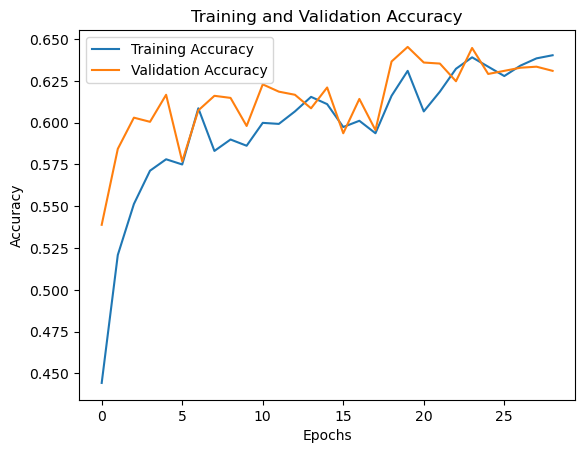

In [44]:
import matplotlib.pyplot as plt
# Extracting accuracy and loss values
df_history = pd.DataFrame(history.history)
accuracy = df_history['accuracy']
val_accuracy = df_history['val_accuracy']
# Plotting accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

#### Export Data

In [16]:
df_matrix.to_csv(f'{model_dir}matrix-{model_save_no}.csv')
df_metrics.to_csv(f'{model_dir}metrics-{model_save_no}.csv')
df_history.to_csv(f'{model_dir}history-{model_save_no}.csv')